# Plots

In [1]:
import os
import datetime
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

from astropy.time import Time

In [2]:
mpl.rc('font', family='sans serif', size=16)

### astroplan observer

In [3]:
from astroplan import Observer
import astropy.coordinates as coord
from astropy import units as u,constants as c

In [4]:
# ssl_lat = 37.88104134417581
# ssl_lon = -122.24409702688845
# ssl_alt = 397*u.m + 20*u.m # height of roof
# observer = Observer(latitude=ssl_lat, longitude=ssl_lon, elevation=ssl_alt, timezone='US/Pacific')

In [5]:
# Define location
keckhq_lat = 20.02435
keckhq_lon = -155.66584
keckhq_alt = 816*u.m
observer = Observer(latitude=keckhq_lat, longitude=keckhq_lon, elevation=keckhq_alt, timezone='US/Hawaii')

### pvlib location

In [6]:
import pvlib as pv

In [7]:
# loc = pv.location.Location(ssl_lat, ssl_lon, 'US/Pacific', ssl_alt.to(u.m).value, 'SSL')
loc = pv.location.Location(keckhq_lat, keckhq_lon, 'US/Hawaii', keckhq_alt.to(u.m).value, 'WMKO HQ')

In [8]:
def plot_irradiance(date_start, date_end, loc=loc):
    
    times = pd.date_range(start=date_start, end=date_end, freq='1min', tz=loc.tz)
    ephem_data = loc.get_solarposition(times)
    clearsky   = loc.get_clearsky(times, model='ineichen')
    sunrise = observer.sun_rise_time(Time.now(), horizon=0*u.deg, which='previous')
    sunset  = observer.sun_set_time(Time.now(), horizon=0*u.deg, which='nearest')
    sunrise30 = observer.sun_rise_time(Time.now(), horizon=30*u.deg, which='previous')
    sunset30  = observer.sun_set_time(Time.now(), horizon=30*u.deg, which='nearest')

    dtrise   = sunrise.to_datetime(timezone=observer.timezone)
    dtrise30 = sunrise30.to_datetime(timezone=observer.timezone)
    dtset    = sunset.to_datetime(timezone=observer.timezone)
    dtset30  = sunset30.to_datetime(timezone=observer.timezone)

    print('Sun rises at {}'.format(dtrise.time()))
    print('Sun above AM 2 at {}'.format(dtrise30.time()))
    print('Sun below AM 2 at {}'.format(dtset30.time()))
    print('Sun sets at {}'.format(dtset.time()))
    
    # Irradiance plot
    # https://pvlib-python.readthedocs.io/en/stable/user_guide/clearsky.html

    columns = ['jd', 'min_irrad', 'max_irrad', 'sens', 'voltage', 'solar_irrad', 'temp']

    datafile = 'irrad_{}.csv'.format(date_start)
    df = pd.read_csv(datafile, names=columns)
    dts = Time(df.jd, format='jd').to_datetime()

    plt.figure(figsize=(12,5))
    plt.axvspan(dtrise, dtrise30, color='k', alpha=0.1);plt.axvspan(dtset30,dtset, color='k', alpha=0.1)
    plt.axvspan(times[0], dtrise, color='k', alpha=0.5);plt.axvspan(dtset,times[-1], color='k', alpha=0.5)
    gaps = np.argwhere(np.diff(dts) > datetime.timedelta(seconds=2)); prev = 0
    for gap in np.append(gaps, [-1]):
        plt.plot(dts[prev+1:gap], df.solar_irrad[prev+1:gap], color='C0'); prev = gap
    clearsky['dni'].plot(color='C1') # dni = direct normal incidence
    plt.xlabel('Time');plt.ylabel('Irradiance [W/m^2]');
    plt.gca().xaxis.set_major_formatter(mpl.dates.DateFormatter("%H:%M", tz=observer.timezone))
    plt.xlim((sunrise-1*u.hour).to_datetime(timezone=observer.timezone), 
            (sunset+1*u.hour).to_datetime(timezone=observer.timezone));
    # plt.xlim(dts[-100], dts[-1]);plt.ylim(bottom=np.min(df.solar_irrad[-100:])*.9)

Sun rises at 06:10:57.036012
Sun above AM 2 at 08:19:02.357634
Sun below AM 2 at 16:25:15.272382
Sun sets at 18:33:13.802248


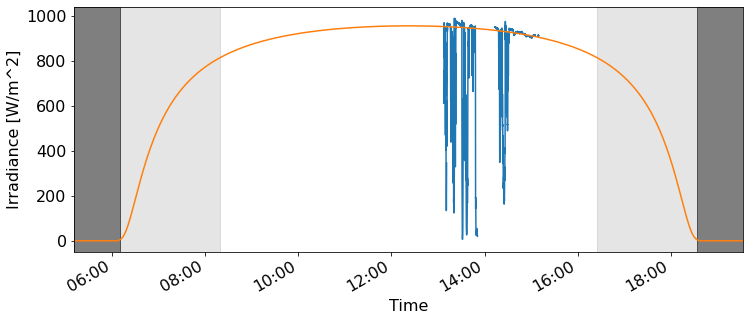

In [34]:
plot_irradiance('2022-09-02', '2022-09-03')

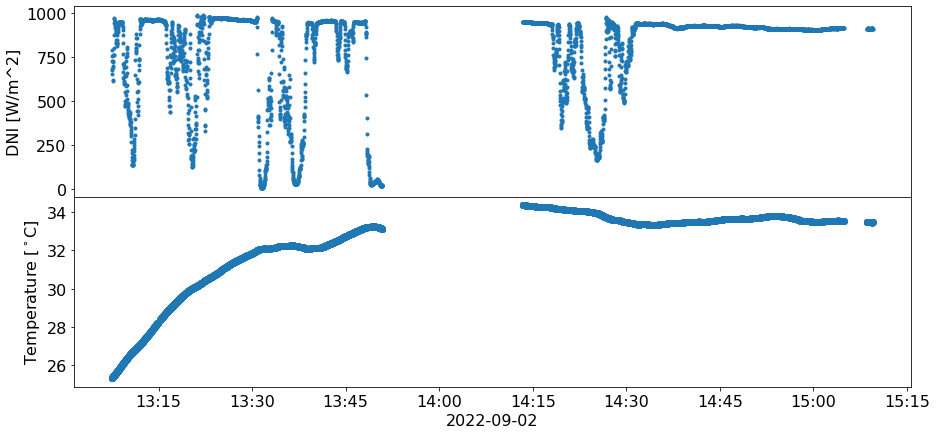

In [33]:
date = '2022-09-02'

datafile = 'irrad_{}.csv'.format(date)

columns = ['jd', 'min_irrad', 'max_irrad', 'sens', 'voltage', 'solar_irrad', 'temp']
df = pd.read_csv(datafile, names=columns)
dts = Time(df.jd, format='jd').to_datetime()

fig, (iax, tax) = plt.subplots(2,1, figsize=(15,7), sharex=True, gridspec_kw={'hspace':0})

# iax.scatter(dts, 1000*df['voltage']/df['sens'])
iax.scatter(dts, df['solar_irrad'], marker='.')
iax.set(ylabel='DNI [W/m^2]')

tax.xaxis.set_major_formatter(mpl.dates.DateFormatter("%H:%M", tz=observer.timezone))
tax.scatter(dts, df['temp'])
tax.set(xlabel='{}'.format(date), ylabel='Temperature [$^\circ$C]');

In [32]:
df['temp'].values*(9/5) + 32

array([77.58908691, 77.60446777, 77.6199585 , ..., 92.69927063,
       92.69822693, 92.70045166])

# Sun position

Current elevation: 69.1 deg
Current airmass: 1.07


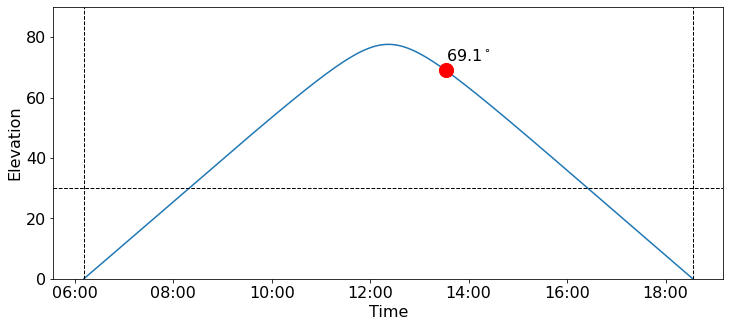

In [77]:
now = Time.now()
sun_now = coord.get_sun(now).transform_to(coord.AltAz(location=observer.location))
sun = ephem_data[ephem_data.elevation > 0]
plt.figure(figsize=(12,5))
plt.plot(sun.index, sun.elevation)
alt = sun_now.alt.to(u.deg).value; az  = sun_now.az.to(u.deg).value
plt.scatter([now.to_datetime()], [alt], color='r', marker='o', s=200, zorder=10)
plt.text(now.to_datetime(timezone=observer.timezone), alt+2, r'{:.1f}$^\circ$'.format(alt), ha='left', va='bottom')
plt.axhline(30, color='k', ls='--', lw=1)
plt.axvline(sunrise.to_datetime(timezone=observer.timezone), color='k', ls='--', lw=1)
plt.axvline( sunset.to_datetime(timezone=observer.timezone), color='k', ls='--', lw=1)
plt.gca().xaxis.set_major_formatter(mpl.dates.DateFormatter("%H:%M", tz=observer.timezone))
plt.ylim(0, 90); plt.xlabel('Time'); plt.ylabel('Elevation');
print('Current elevation: {:.1f} deg'.format(alt))
print('Current airmass: {:.2f}'.format(1/np.cos(90*u.deg - alt*u.deg)))

11.5 deg setting elevation is obstructed by trees

In [78]:
real_sunset  = observer.sun_set_time(Time.now(), horizon=12*u.deg, which='nearest')
print('{:.0f} minutes until sunset'.format((real_sunset - Time.now()).to(u.min)))

249 min minutes until sunset


# Offset guiding test

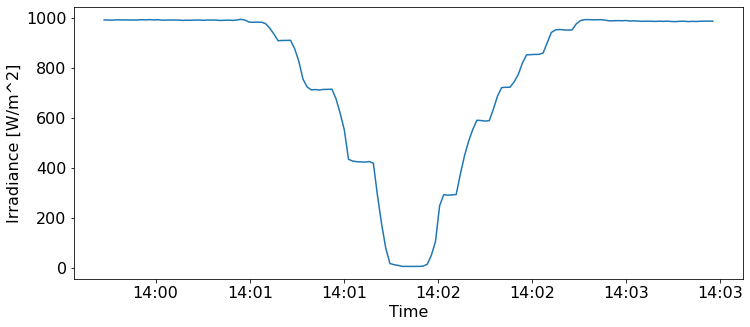

In [76]:
columns = ['jd', 'min_irrad', 'max_irrad', 'sens', 'voltage', 'solar_irrad', 'temp']
df = pd.read_csv('offset_test.csv', names=columns)
dts = Time(df.jd, format='jd').to_datetime()
plt.figure(figsize=(12,5))
gaps = np.argwhere(np.diff(dts) > datetime.timedelta(seconds=2)); prev = 0
for gap in np.append(gaps, [-1]):
    plt.plot(dts[prev+1:gap], df.solar_irrad[prev+1:gap], color='C0'); prev = gap
# clearsky['dni'].plot(color='C1') # dni = direct normal incidence
plt.xlabel('Time');plt.ylabel('Irradiance [W/m^2]');
plt.gca().xaxis.set_major_formatter(mpl.dates.DateFormatter("%H:%M", tz=observer.timezone))
# plt.xlim((sunrise-1*u.hour).to_datetime(timezone=observer.timezone), 
#           (sunset+1*u.hour).to_datetime(timezone=observer.timezone));
# plt.xlim(dts[-100], dts[-1]);plt.ylim(bottom=np.min(df.solar_irrad[-100:])*.9)